<a href="https://colab.research.google.com/github/Valiev-Koyiljon/Pytorch-HousePricePrediction/blob/main/BostonHousingDatasetRegressionWithPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House price prediction using linear regression

We will use the boston housing dataset, which is available on Kaggle platform: https://www.kaggle.com/c/boston-housing/

In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Hyperparameters
batch_size=64
learning_rate=0.005

In [ ]:
# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

## Dataset & Data loaders

In [ ]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

Using downloaded and verified file: ./BostonHousing.csv


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [ ]:
inputs

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [ ]:
targets[0: 10]

array([[24. ],
       [21.6],
       [34.7],
       [33.4],
       [36.2],
       [28.7],
       [22.9],
       [27.1],
       [16.5],
       [18.9]])

##Data Normalization

In [ ]:
# Normalize the input features using StandardScaler
scaler = StandardScaler()
normalized_inputs = scaler.fit_transform(inputs)

#Converting to the Pytorch dataset

In [ ]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(normalized_inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [436, 70])


train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)


## Model

Create a class for Boston Housing and we will call the class for its prediction

In [ ]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)# input_size=13, output_size = 1

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


model = HousingModel() # calling our model

## Training

We will evaluate the model with validation dataset to check its performance

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = [] # save the track of validation loss
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
result = evaluate(model, val_loader)
result

{'val_loss': 551.571533203125}

In [ ]:
history = fit(5, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 477.6177
Epoch [1], val_loss: 419.2733
Epoch [2], val_loss: 369.6681
Epoch [3], val_loss: 326.7618
Epoch [4], val_loss: 289.2943


In [ ]:
history1 = fit(5, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 255.7081
Epoch [1], val_loss: 226.4073
Epoch [2], val_loss: 200.8880
Epoch [3], val_loss: 178.1747
Epoch [4], val_loss: 158.3406


In [ ]:
history2 = fit(22, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 141.3719
Epoch [1], val_loss: 126.4237
Epoch [2], val_loss: 113.3805
Epoch [3], val_loss: 102.0702
Epoch [4], val_loss: 91.8870
Epoch [5], val_loss: 83.2688
Epoch [6], val_loss: 75.6535
Epoch [7], val_loss: 68.9751
Epoch [8], val_loss: 63.2016
Epoch [9], val_loss: 58.1044
Epoch [10], val_loss: 53.5821
Epoch [11], val_loss: 49.6699
Epoch [12], val_loss: 46.0963
Epoch [13], val_loss: 43.0274
Epoch [14], val_loss: 40.4257
Epoch [15], val_loss: 38.0952
Epoch [16], val_loss: 36.0836
Epoch [17], val_loss: 34.2718
Epoch [18], val_loss: 32.7306
Epoch [19], val_loss: 31.3975
Epoch [20], val_loss: 30.2116
Epoch [21], val_loss: 29.1022


In [ ]:
history3 = fit(5, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 28.1290
Epoch [1], val_loss: 27.3402
Epoch [2], val_loss: 26.6060
Epoch [3], val_loss: 25.9060
Epoch [4], val_loss: 25.3761


It is time to plot the validation losses with epochs



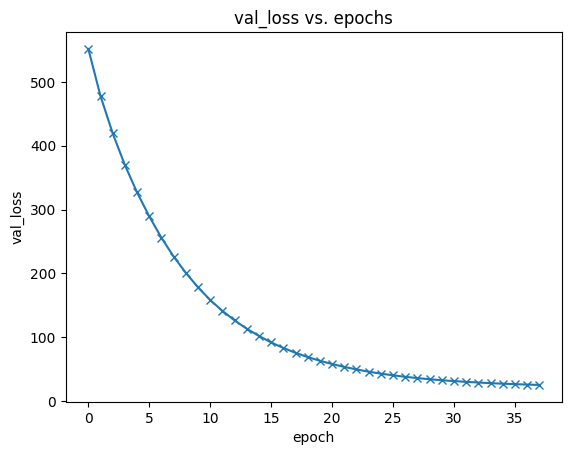

In [ ]:
losses = [r['val_loss'] for r in [result] + history+history1+history2+history3]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

In [ ]:
result = evaluate(model, val_loader)
result

{'val_loss': 25.37608528137207}

## Prediction

Function to predict the single output from single input

In [ ]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [ ]:
x, target = val_ds[53]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 1.3921, -0.4877,  1.0160, -0.2726,  0.2186, -0.5109,  0.0862, -0.4215,
         1.6612,  1.5309,  0.8066,  0.1323,  0.7677])
Target:  19.100000381469727
Prediction: 13.988216400146484


# Comparing the predicted output and true output

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


model.eval()

# Iterate over validation batches
for input, target in train_loader:
    with torch.no_grad():
        pred = model(input)
    predicted =  pred.squeeze().numpy()
    targeted =  target.numpy()
print(predicted)
print(targeted.flatten())
mse = mean_squared_error(targeted.flatten(), predicted)
print(mse)

[22.539627  22.792994  30.69252    1.1744671 23.0208     6.8960295
 21.57606   35.757023  11.329687  19.482283  21.451746  15.680487
 30.81924   21.692753  20.99983   16.665848   4.0790043 17.70127
 39.291     19.515272  23.797834  17.59725   19.684612  12.699602
 26.349007  13.133829  15.616034  22.495481  18.726692  32.223877
 12.5795965 22.939753  16.088005  25.073341  15.87231   34.551792
 30.889284  15.939639  24.84589   30.157528  16.549566  23.454508
 14.366437  22.33147   26.65532   15.2384815 10.363696  19.61473
 23.642906  17.854149  19.296919   8.390482 ]
[21.4 24.1 37.9  8.8 15.6  8.5 15.3 43.1 11.5 23.1 22.7 14.1 31.6 24.3
 20.4 18.4  7.4 13.1 50.  17.1 21.9 13.3 20.  10.2 23.6 10.9 14.2 23.
 20.  36.4 14.  22.2 19.5 24.8 27.9 50.  34.9 23.1 24.7 30.7 15.4 25.
 11.7 21.5 30.1 13.4 13.4 18.7 23.2 19.4 19.6  8.7]
19.458712


#### Before we train the model, we should do data preprocessing and feature engineering to improve the model accuracy. The aim of this notebook is to learn how to train simple regression model.

Now, We will save the model and use the saved model parametrs later on.

## Save and upload

In [ ]:
torch.save(model.state_dict(), 'housing-linear.pth')

To download the saved model on google colab

In [ ]:
from google.colab import files


model_path = 'housing-linear.pth'
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>